In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
import pickle
from scipy import signal
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

### Vertical velocity variance at different timescales

* Using WKB weighted vertical velocity ($w^*$)
* Compare $std(^*)$ at 12 hrs, 1 day, 2.5 days and 5 days

In [2]:
def calc_rho(ds, tt, tAlpha=2.E-4, sBeta=7.4E-4, rhoNil=999.8):
    '''calculate density rho as rho = rhoRef + rho_anom at time tt'''
    Tref = np.squeeze(ds['THETA'][0,...])
    Sref = np.squeeze(ds['SALT'][0,...])
    rhoRef=np.expand_dims(np.expand_dims(ds['rhoRef'][:],1),1)+np.zeros_like(Tref)
    rho = rhoRef + rhoNil*np.ones_like(Tref)*(sBeta*(ds['SALT'][tt,...]-Sref)-
                                              tAlpha*(ds['THETA'][tt,...]-Tref))
    return(rho)

def calc_N2(Z, rho, rhoNil=999.8, g=9.81):
    Zexp = np.expand_dims(np.expand_dims(Z,1),1)+np.zeros_like(rho)
    N2 = -(g/rhoNil)*(rho.data[2:,...]-rho.data[:-2,...])/(Zexp[2:,...]-Zexp[:-2,...])
    return(N2)

def plot_6panels(fld1,fld2,fld3,fld4,fld5,fld6, vmin, vmax,cmap, units,fldname):
    fig, ((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3,figsize=(12,9), sharey=True, sharex=True)
    ax0.set_facecolor('tan')
    ax1.set_facecolor('tan')
    ax2.set_facecolor('tan')
    ax3.set_facecolor('tan')
    ax4.set_facecolor('tan')
    ax5.set_facecolor('tan')

    pc = ax0.pcolormesh(lon,lat, np.ma.masked_array(fld1,mask=mask[zz,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax0.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    pc = ax1.pcolormesh(lon,lat, np.ma.masked_array(fld2,mask=mask[zz2,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax1.contour(lon,lat,depth, levels=[0,500], colors=['k','0.5'])

    pc = ax2.pcolormesh(lon,lat, np.ma.masked_array(fld3,mask=mask[zz3,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax2.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    pc = ax3.pcolormesh(lon,lat, np.ma.masked_array(fld4,mask=mask[zz4,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax3.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    pc = ax4.pcolormesh(lon,lat, np.ma.masked_array(fld5,mask=mask[zz5,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax4.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    pc = ax5.pcolormesh(lon,lat, np.ma.masked_array(fld6,mask=mask[zz6,:,:]),
                      cmap=cmap,vmin=vmin, vmax=vmax)
    ax5.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.91, 0.125, 0.022, 0.755])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=cbar_ax, orientation='vertical',label=units)

    ax3.set_xlabel('lon')
    ax4.set_xlabel('lon')
    ax5.set_xlabel('lon')
    ax0.set_ylabel('lat')
    ax3.set_ylabel('lat')

    ax0.set_title(r'%s at %1.1f m'%(fldname,Zl[zz]))
    ax1.set_title('%1.1f m'%(Zl[zz2]))
    ax2.set_title('%1.1f m'%(Zl[zz3]))
    ax3.set_title('%1.1f m'%(Zl[zz4]))
    ax4.set_title('%1.1f m'%(Zl[zz5]))
    ax5.set_title('%1.1f m'%(Zl[zz6]))

    for ax in [ax0,ax1,ax2,ax3,ax4,ax5]:
        ax.set_aspect(1)
        ax.set_ylim(27,35)
        ax.set_xlim(-121,-114)
    return(ax0,ax1,ax2,ax3,ax4,ax5)

In [3]:
outdir = '/data/SO2/sio-kramosmusalem/04_feb_TSref_output/'
levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)

In [4]:
# Grid data
depth = ds.Depth[:]
LAT = ds['YC'][:]
LON = ds['XC'][:]-360
lat = ds.YC[:,0].data
lon = ds.XC[0,:].data-360

Z = ds['Z'][:]
Zl = ds['Zl'][:]

nx = len(lon)
ny = len(lat)
nz = len(Z)

# centers mask
hFacC = ds['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

# cell areas and cell volumes
rA = ds['rA'][:]
drF = ds['drF'][:]

rA_exp = np.expand_dims(rA[:,:],0)
drF_exp = np.expand_dims(np.expand_dims(drF[:],1),1)
rA_exp = rA_exp + np.zeros(hFacC[:,:,:].shape)
drF_exp = drF_exp + np.zeros(hFacC[:,:,:].shape)
volumes = hFacC[:,:,:]*drF_exp*rA_exp

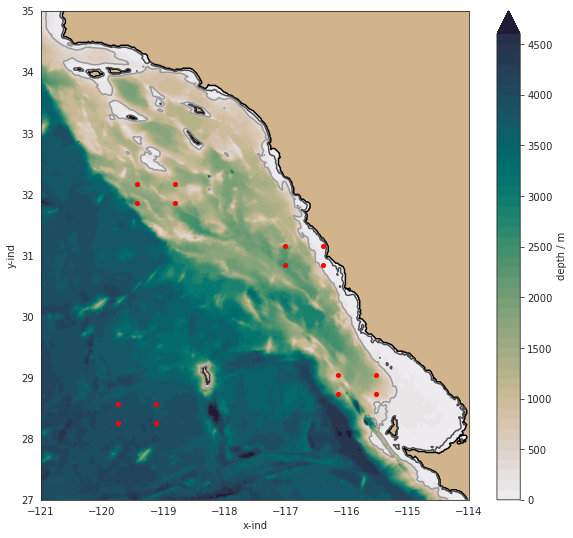

In [37]:
sns.set_style('white')
fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')
pc = ax.contourf(LON,LAT,np.ma.masked_array(depth, mask=mask_dep),50,
                 vmin=0, vmax=5000, cmap=cmo.cm.rain, extend='max')
cb = plt.colorbar(pc, extend='max',label='depth / m')
cn = ax.contour(lon,lat,depth, colors=['0','0.3','0.6'], levels=[0,20,250])

lon_inds = [401,425,385,336,301,278,240,200,180,80,32,22]
lat_inds = [32,64,148,174,250,308,360,420,429,472,477,500]

lons_area1 = [100,140,100,140]
lats_area1 = [310,330,330,310]

lons_area2 = [310,350,310,350]
lats_area2 = [110,130,130,110]

lons_area3 = [255,295,255,295]
lats_area3 = [245,265,265,245]

lons_area4 = [80,120,80,120]
lats_area4 = [80,100,100,80]

# ssh transects
#for ii in range(len(lon_inds)):
#    ax.plot(lon[lon_inds[ii]],lat[lat_inds[ii]],'ro', markersize=4)
#    print('Depth at station: %1.1f m ' %depth[lat_inds[ii],lon_inds[ii]])

for ii in range(len(lons_area1)):
    ax.plot(lon[lons_area1[ii]],lat[lats_area1[ii]],'ro', markersize=4)
    ax.plot(lon[lons_area2[ii]],lat[lats_area2[ii]],'ro', markersize=4)
    ax.plot(lon[lons_area3[ii]],lat[lats_area3[ii]],'ro', markersize=4)
    ax.plot(lon[lons_area4[ii]],lat[lats_area4[ii]],'ro', markersize=4)
     
cb.set_label('depth / m')
ax.set_xlabel('x-ind')
ax.set_ylabel('y-ind')
ax.set_xlim(-121,-114)
ax.set_ylim(27,35)
ax.set_aspect(1)

In [5]:
# Define constants for rho calculations
Tref = np.squeeze(ds['THETA'][0,...])
Sref = np.squeeze(ds['SALT'][0,...])
tAlpha=2.E-4
sBeta=7.4E-4
rhoNil=999.8
rhoRef=np.expand_dims(np.expand_dims(ds['rhoRef'][:],1),1)+np.zeros_like(Tref)

In [6]:
# Calculate N temporal average at different timescales
# This cell is very slow
N1 = np.zeros((nz-2,ny,nx))
N2 = np.zeros((nz-2,ny,nx))
N3 = np.zeros((nz-2,ny,nx))
N4 = np.zeros((nz-2,ny,nx))

tscales = [72,144,360,720] # time indices for 12 hrs, 1 day, 2.5 days, 5 days

for tt in range(tscales[-1]):
    rho = calc_rho(ds,tt)
    N = np.sqrt(calc_N2(Z,rho))
    if tt<=tscales[0]:
        N1 = N1 + N
        N2 = N2 + N
        N3 = N3 + N
        N4 = N4 + N
    elif tt>tscales[0] and tt<=tscales[1]:
        N2 = N2 + N
        N3 = N3 + N
        N4 = N4 + N
    
    elif tt>tscales[1] and tt<=tscales[2]:
        N3 = N3 + N
        N4 = N4 + N
    else:
        N4 = N4 + N
    
    if tt%10==0:
        print(tt)

N1 = N1/tscales[0] # mean N (temporal)
N2 = N2/tscales[1]
N3 = N3/tscales[2]
N4 = N4/tscales[3]

## Saving the objects:
#with open('mean_Ns_12h_1d_2p5d_5d_04_feb_TSref.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([N1,N2,N3,N4], f) 
# These lines give the error: AttributeError: Can't pickle local object 'read_3D_chunks.<locals>.load_chunk'

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710


In [7]:
# Slow cell
N1_vol = (np.nansum(np.nansum(np.nansum(N1*volumes[1:-1,...], axis=0),axis=0),axis=0)/
         np.nansum(np.nansum(np.nansum(volumes[1:-1,...], axis=0),axis=0),axis=0))

N1_area = (np.nansum(np.nansum(N1*rA_exp[1:-1,...],axis=1),axis=1)/
          np.nansum(np.nansum(rA_exp[1:-1,...],axis=1),axis=1))

N2_vol = (np.nansum(np.nansum(np.nansum(N2*volumes[1:-1,...], axis=0),axis=0),axis=0)/
         np.nansum(np.nansum(np.nansum(volumes[1:-1,...], axis=0),axis=0),axis=0))

N2_area = (np.nansum(np.nansum(N2*rA_exp[1:-1,...],axis=1),axis=1)/
          np.nansum(np.nansum(rA_exp[1:-1,...],axis=1),axis=1))

N3_vol = (np.nansum(np.nansum(np.nansum(N3*volumes[1:-1,...], axis=0),axis=0),axis=0)/
         np.nansum(np.nansum(np.nansum(volumes[1:-1,...], axis=0),axis=0),axis=0))

N3_area = (np.nansum(np.nansum(N3*rA_exp[1:-1,...],axis=1),axis=1)/
          np.nansum(np.nansum(rA_exp[1:-1,...],axis=1),axis=1))

N4_vol = (np.nansum(np.nansum(np.nansum(N4*volumes[1:-1,...], axis=0),axis=0),axis=0)/
         np.nansum(np.nansum(np.nansum(volumes[1:-1,...], axis=0),axis=0),axis=0))

N4_area = (np.nansum(np.nansum(N4*rA_exp[1:-1,...],axis=1),axis=1)/
          np.nansum(np.nansum(rA_exp[1:-1,...],axis=1),axis=1))

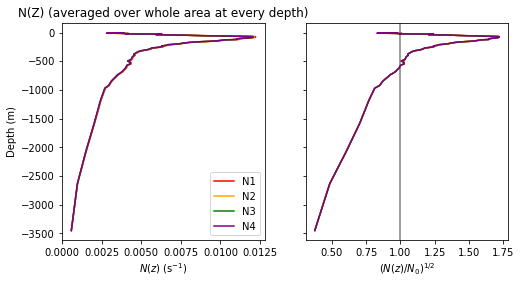

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), sharey=True)
ax1.plot(N1_area,Z[1:-1], 'r',label='N1')
ax1.plot(N2_area,Z[1:-1], 'orange',label='N2')
ax1.plot(N3_area,Z[1:-1], 'g',label='N3')
ax1.plot(N4_area,Z[1:-1], 'purple',label='N4')
ax1.set_xlabel(r'$N(z)$ (s$^{-1}$)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('N(Z) (averaged over whole area at every depth)')
ax1.legend()
ax2.axvline(1, color='0.5')
ax2.plot(np.sqrt(N1_area/N1_vol),Z[1:-1], 'r')
ax2.plot(np.sqrt(N2_area/N2_vol),Z[1:-1], 'orange')
ax2.plot(np.sqrt(N3_area/N3_vol),Z[1:-1], 'g')
ax2.plot(np.sqrt(N4_area/N4_vol),Z[1:-1], 'purple')

ax2.set_xlabel(r'$(N(z)/N_0)^{1/2}$')
plt.show()

In [9]:
N1_area_exp = np.expand_dims(np.expand_dims(N1_area,1),1)
N1_area_exp = N1_area_exp + np.zeros_like(N1)

N2_area_exp = np.expand_dims(np.expand_dims(N2_area,1),1)
N2_area_exp = N2_area_exp + np.zeros_like(N2)

N3_area_exp = np.expand_dims(np.expand_dims(N3_area,1),1)
N3_area_exp = N3_area_exp + np.zeros_like(N3)

N4_area_exp = np.expand_dims(np.expand_dims(N4_area,1),1)
N4_area_exp = N4_area_exp + np.zeros_like(N4)

In [10]:
# depths
zz = 8
zz2 =15
zz3 = 25
zz4 = 43
zz5 = 60
zz6 = 70
dt = 600

### Plot std and variance

In [11]:
tini = 24
tend = tscales[0]

W1a = (ds['WVEL'][tini:tend,zz,:,:]).data*np.sqrt(N1_area_exp[zz-1]/N1_vol)
W2a = (ds['WVEL'][tini:tend,zz2,:,:]).data*np.sqrt(N1_area_exp[zz-1]/N1_vol)
W3a = (ds['WVEL'][tini:tend,zz3,:,:]).data*np.sqrt(N1_area_exp[zz-1]/N1_vol)
W4a = (ds['WVEL'][tini:tend,zz4,:,:]).data*np.sqrt(N1_area_exp[zz-1]/N1_vol)
W5a = (ds['WVEL'][tini:tend,zz5,:,:]).data*np.sqrt(N1_area_exp[zz-1]/N1_vol)
W6a = (ds['WVEL'][tini:tend,zz6,:,:]).data*np.sqrt(N1_area_exp[zz-1]/N1_vol)

Var1a = (np.sum(W1a*W1a, axis=0)*(dt))/(time[tend]-time[tini])
Var2a = (np.sum(W2a*W2a, axis=0)*(dt))/(time[tend]-time[tini])
Var3a = (np.sum(W3a*W3a, axis=0)*(dt))/(time[tend]-time[tini])
Var4a = (np.sum(W4a*W4a, axis=0)*(dt))/(time[tend]-time[tini])
Var5a = (np.sum(W5a*W5a, axis=0)*(dt))/(time[tend]-time[tini])
Var6a = (np.sum(W6a*W6a, axis=0)*(dt))/(time[tend]-time[tini])

Std1a = np.std(W1a, axis=0)
Std2a = np.std(W2a, axis=0)
Std3a = np.std(W3a, axis=0)
Std4a = np.std(W4a, axis=0)
Std5a = np.std(W5a, axis=0)
Std6a = np.std(W6a, axis=0)

W_tot_a = (ds['WVEL'][tini:tend,1:-1,:,:]).data*np.sqrt(N1_area_exp[:]/N1_vol)
Var_tot_a = np.mean(np.mean((np.sum(W_tot_a*W_tot_a, axis=0)*(dt))/(time[tend]-time[tini]),axis=1),axis=1)
Std_tot_a = np.mean(np.mean(np.std(W_tot_a, axis=0),axis=1),axis=1)

W_A1_a = (ds['WVEL'][tini:tend,1:-1,
                     lats_area1[0]:lats_area1[1],
                     lons_area1[0]:lons_area1[1]]).data*np.sqrt(N1_area_exp[:]/N1_vol)
Var_A1_a = np.mean(np.mean((np.sum(W_A1_a*W_A1_a, axis=0)*(dt))/(time[tend]-time[tini]),axis=1),axis=1)
Std_A1_a = np.mean(np.mean(np.std(W_A1_a, axis=0),axis=1),axis=1)

W_A2_a = (ds['WVEL'][tini:tend,1:-1,
                     lats_area2[0]:lats_area2[1],
                     lons_area2[0]:lons_area2[1]]).data*np.sqrt(N1_area_exp[:]/N1_vol)
Var_A2_a = np.mean(np.mean((np.sum(W_A2_a*W_A2_a, axis=0)*(dt))/(time[tend]-time[tini]),axis=1),axis=1)
Std_A2_a = np.mean(np.mean(np.std(W_A2_a, axis=0),axis=1),axis=1)

W_A3_a = (ds['WVEL'][tini:tend,1:-1,
                     lats_area3[0]:lats_area3[1],
                     lons_area3[0]:lons_area3[1]]).data*np.sqrt(N1_area_exp[:]/N1_vol)
Var_A3_a = np.mean(np.mean((np.sum(W_A3_a*W_A3_a, axis=0)*(dt))/(time[tend]-time[tini]),axis=1),axis=1)
Std_A3_a = np.mean(np.mean(np.std(W_A3_a, axis=0),axis=1),axis=1)

W_A4_a = (ds['WVEL'][tini:tend,1:-1,
                     lats_area4[0]:lats_area4[1],
                     lons_area4[0]:lons_area4[1]]).data*np.sqrt(N1_area_exp[:]/N1_vol)
Var_A4_a = np.mean(np.mean((np.sum(W_A4_a*W_A4_a, axis=0)*(dt))/(time[tend]-time[tini]),axis=1),axis=1)
Std_A4_a = np.mean(np.mean(np.std(W_A4_a, axis=0),axis=1),axis=1)


12 hrs


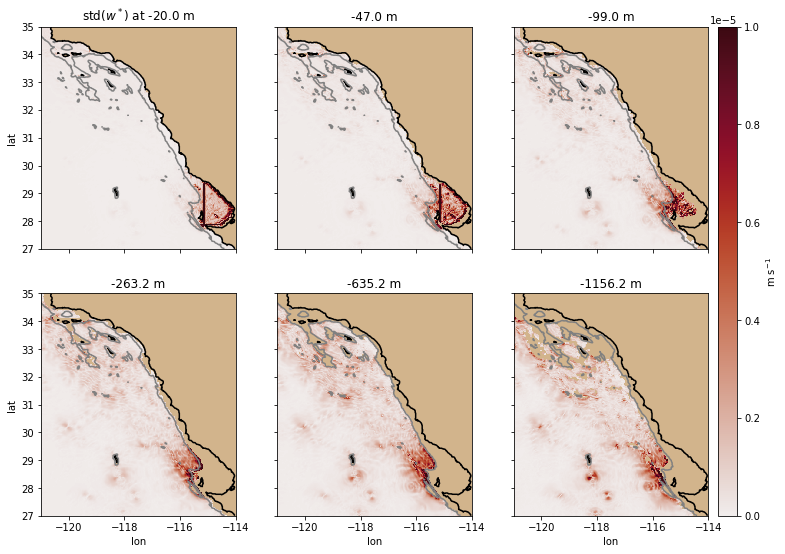

In [12]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1a,Std2a,Std3a,Std4a,Std5a,Std6a,
                                       -1E5,1E-5,cmo.cm.curl,'m s$^{-1}$','std($w^*$)')
print('12 hrs')

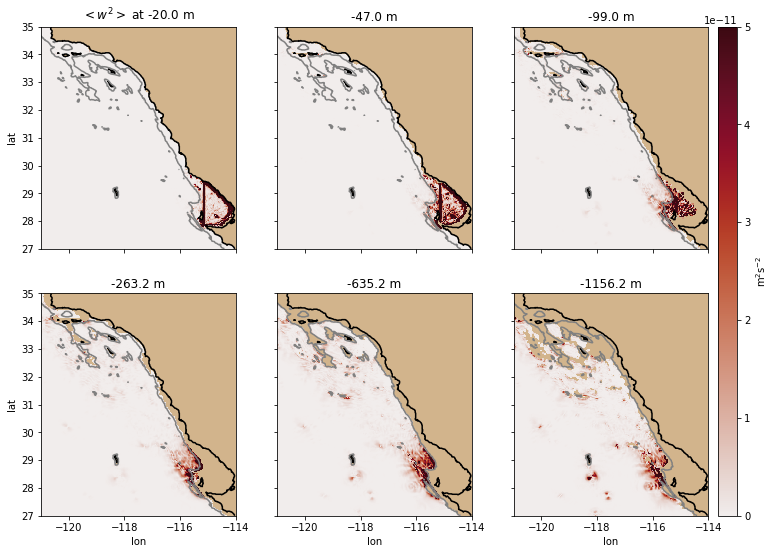

In [13]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1a,Var2a,Var3a,Var4a,Var5a,Var6a,
                                       0,5E-11,cmo.cm.amp,'m$^2$s$^{-2}$','$<w^2>$')

In [14]:
tini = 24
tend = tscales[1]

W1b = (ds['WVEL'][tini:tend,zz,:,:]).data*np.sqrt(N2_area_exp[zz-1]/N2_vol)
W2b = (ds['WVEL'][tini:tend,zz2,:,:]).data*np.sqrt(N2_area_exp[zz-1]/N2_vol)
W3b = (ds['WVEL'][tini:tend,zz3,:,:]).data*np.sqrt(N2_area_exp[zz-1]/N2_vol)
W4b = (ds['WVEL'][tini:tend,zz4,:,:]).data*np.sqrt(N2_area_exp[zz-1]/N2_vol)
W5b = (ds['WVEL'][tini:tend,zz5,:,:]).data*np.sqrt(N2_area_exp[zz-1]/N2_vol)
W6b = (ds['WVEL'][tini:tend,zz6,:,:]).data*np.sqrt(N2_area_exp[zz-1]/N2_vol)

Var1b = (np.sum(W1b*W1b, axis=0)*(dt))/(time[tend]-time[tini])
Var2b = (np.sum(W2b*W2b, axis=0)*(dt))/(time[tend]-time[tini])
Var3b = (np.sum(W3b*W3b, axis=0)*(dt))/(time[tend]-time[tini])
Var4b = (np.sum(W4b*W4b, axis=0)*(dt))/(time[tend]-time[tini])
Var5b = (np.sum(W5b*W5b, axis=0)*(dt))/(time[tend]-time[tini])
Var6b = (np.sum(W6b*W6b, axis=0)*(dt))/(time[tend]-time[tini])

Std1b = np.std(W1b, axis=0)
Std2b = np.std(W2b, axis=0)
Std3b = np.std(W3b, axis=0)
Std4b = np.std(W4b, axis=0)
Std5b = np.std(W5b, axis=0)
Std6b = np.std(W6b, axis=0)



1 day


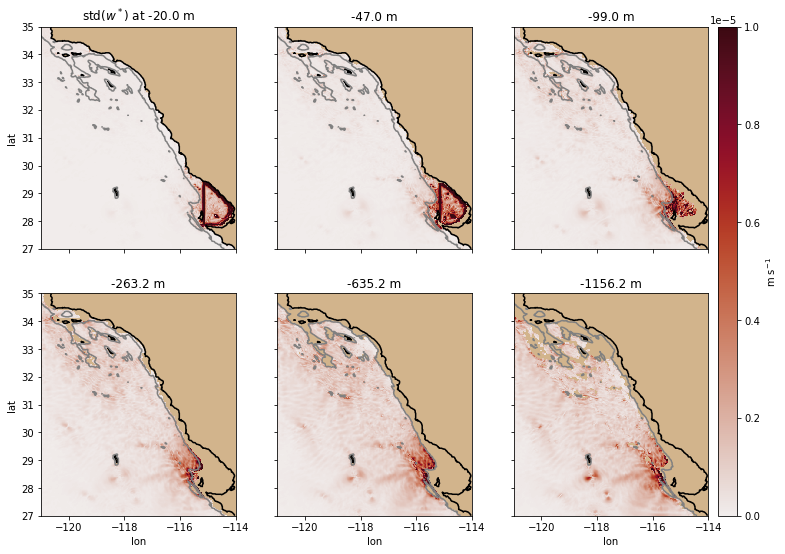

In [15]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1b,Std2b,Std3b,Std4b,Std5b,Std6b,
                                       -1E-5,1E-5,cmo.cm.curl,'m s$^{-1}$','std($w^*$)')
print('1 day')

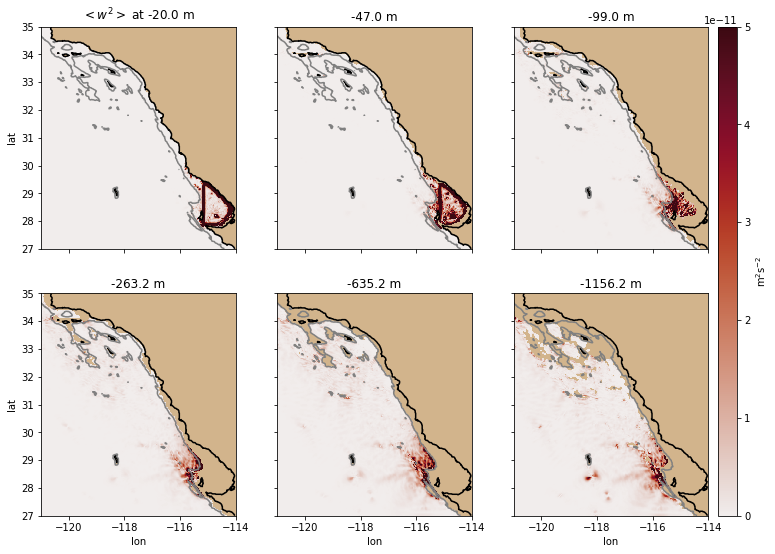

In [16]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1b,Var2b,Var3b,Var4b,Var5b,Var6b,
                                       0,5E-11,cmo.cm.amp,'m$^2$s$^{-2}$','$<w^2>$')

In [17]:
tini = 24
tend = tscales[2]

W1c = (ds['WVEL'][tini:tend,zz,:,:]).data*np.sqrt(N3_area_exp[zz-1]/N3_vol)
W2c = (ds['WVEL'][tini:tend,zz2,:,:]).data*np.sqrt(N3_area_exp[zz-1]/N3_vol)
W3c = (ds['WVEL'][tini:tend,zz3,:,:]).data*np.sqrt(N3_area_exp[zz-1]/N3_vol)
W4c = (ds['WVEL'][tini:tend,zz4,:,:]).data*np.sqrt(N3_area_exp[zz-1]/N3_vol)
W5c = (ds['WVEL'][tini:tend,zz5,:,:]).data*np.sqrt(N3_area_exp[zz-1]/N3_vol)
W6c = (ds['WVEL'][tini:tend,zz6,:,:]).data*np.sqrt(N3_area_exp[zz-1]/N3_vol)

Var1c = (np.sum(W1c*W1c, axis=0)*(dt))/(time[tend]-time[tini])
Var2c = (np.sum(W2c*W2c, axis=0)*(dt))/(time[tend]-time[tini])
Var3c = (np.sum(W3c*W3c, axis=0)*(dt))/(time[tend]-time[tini])
Var4c = (np.sum(W4c*W4c, axis=0)*(dt))/(time[tend]-time[tini])
Var5c = (np.sum(W5c*W5c, axis=0)*(dt))/(time[tend]-time[tini])
Var6c = (np.sum(W6c*W6c, axis=0)*(dt))/(time[tend]-time[tini])

Std1c = np.std(W1c, axis=0)
Std2c = np.std(W2c, axis=0)
Std3c = np.std(W3c, axis=0)
Std4c = np.std(W4c, axis=0)
Std5c = np.std(W5c, axis=0)
Std6c = np.std(W6c, axis=0)

2.5 days


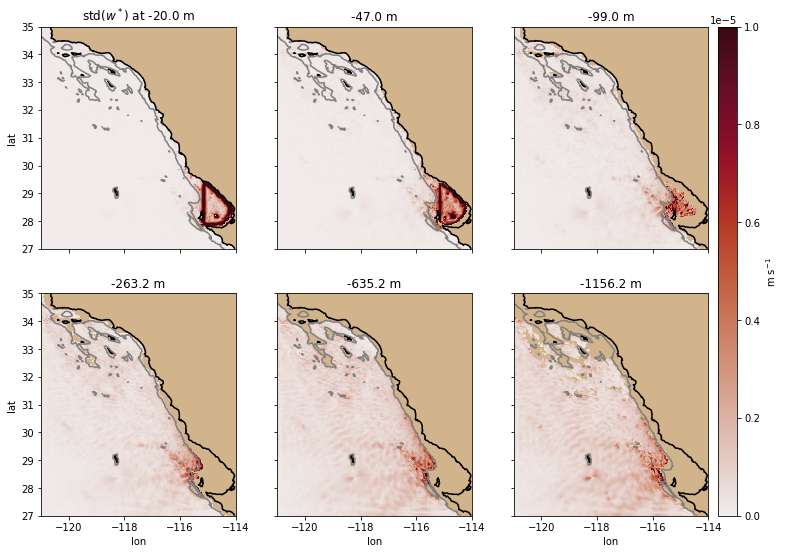

In [18]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1c,Std2c,Std3c,Std4c,Std5c,Std6c,
                                       -1E-5,1E-5,cmo.cm.curl,'m s$^{-1}$','std($w^*$)')
print('2.5 days')

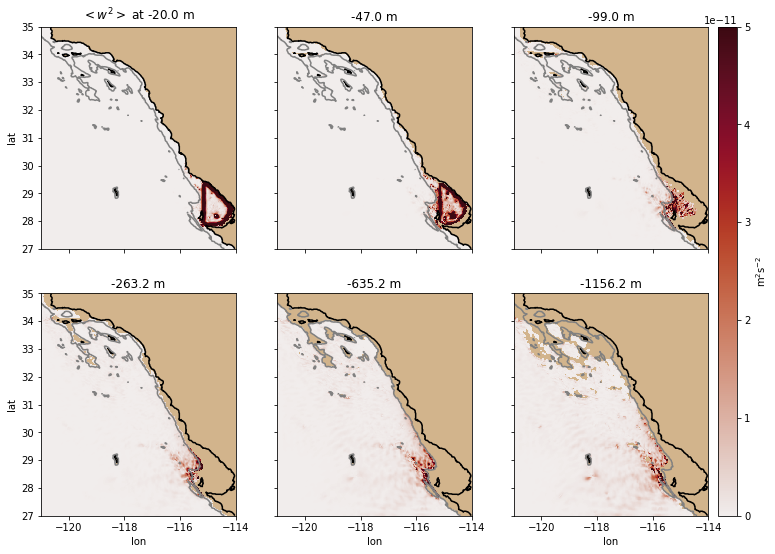

In [19]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1c,Var2c,Var3c,Var4c,Var5c,Var6c,
                                       0,5E-11,cmo.cm.amp,'m$^2$s$^{-2}$','$<w^2>$')

In [21]:
tini = 24
tend = tscales[3]-1

W1d = (ds['WVEL'][tini:tend,zz,:,:]).data*np.sqrt(N4_area_exp[zz-1]/N4_vol)
W2d = (ds['WVEL'][tini:tend,zz2,:,:]).data*np.sqrt(N4_area_exp[zz-1]/N4_vol)
W3d = (ds['WVEL'][tini:tend,zz3,:,:]).data*np.sqrt(N4_area_exp[zz-1]/N4_vol)
W4d = (ds['WVEL'][tini:tend,zz4,:,:]).data*np.sqrt(N4_area_exp[zz-1]/N4_vol)
W5d = (ds['WVEL'][tini:tend,zz5,:,:]).data*np.sqrt(N4_area_exp[zz-1]/N4_vol)
W6d = (ds['WVEL'][tini:tend,zz6,:,:]).data*np.sqrt(N4_area_exp[zz-1]/N4_vol)

Var1d = (np.sum(W1d*W1d, axis=0)*(dt))/(time[tend]-time[tini])
Var2d = (np.sum(W2d*W2d, axis=0)*(dt))/(time[tend]-time[tini])
Var3d = (np.sum(W3d*W3d, axis=0)*(dt))/(time[tend]-time[tini])
Var4d = (np.sum(W4d*W4d, axis=0)*(dt))/(time[tend]-time[tini])
Var5d = (np.sum(W5d*W5d, axis=0)*(dt))/(time[tend]-time[tini])
Var6d = (np.sum(W6d*W6d, axis=0)*(dt))/(time[tend]-time[tini])

Std1d = np.std(W1d, axis=0)
Std2d = np.std(W2d, axis=0)
Std3d = np.std(W3d, axis=0)
Std4d = np.std(W4d, axis=0)
Std5d = np.std(W5d, axis=0)
Std6d = np.std(W6d, axis=0)

5 days


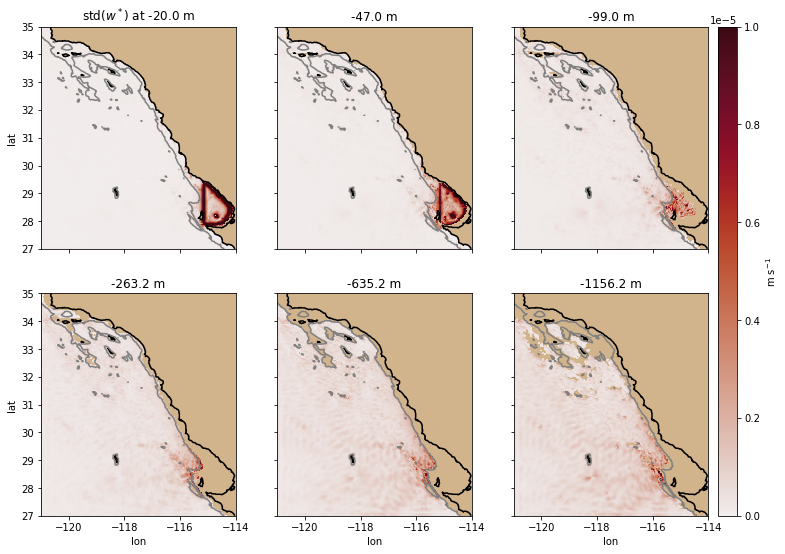

In [22]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1d,Std2d,Std3d,Std4d,Std5d,Std6d,
                                       -1E-5,1E-5,cmo.cm.curl,'m s$^{-1}$','std($w^*$)')
print('5 days')

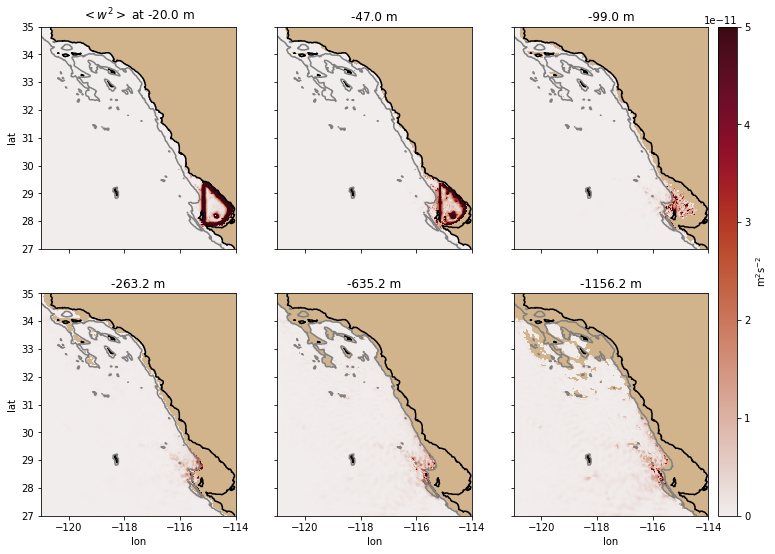

In [23]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1d,Var2d,Var3d,Var4d,Var5d,Var6d,
                                       0,5E-11,cmo.cm.amp,'m$^2$s$^{-2}$','$<w^2>$')

### Differences wrt 1 day variance or std

12 hrs/1 day


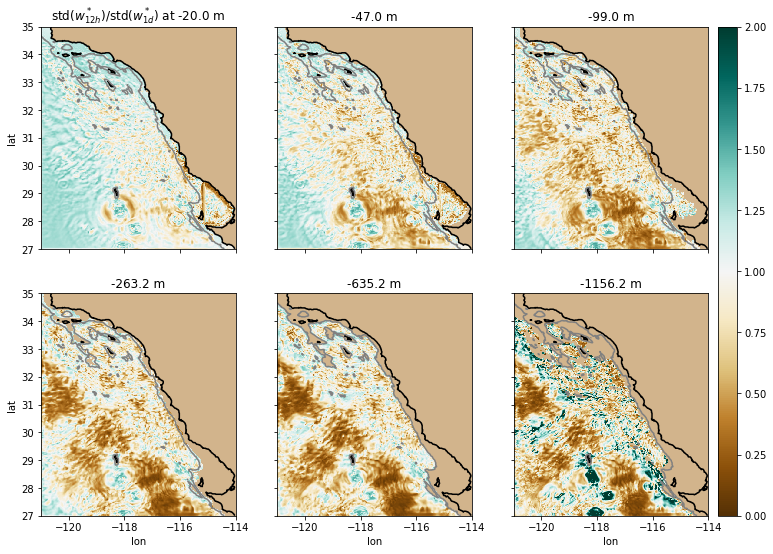

2.5 days/1 day


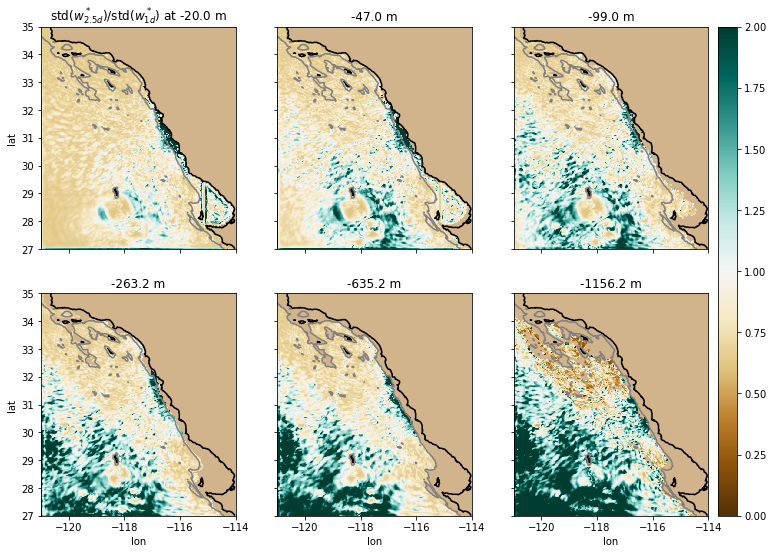

5 days/1 day


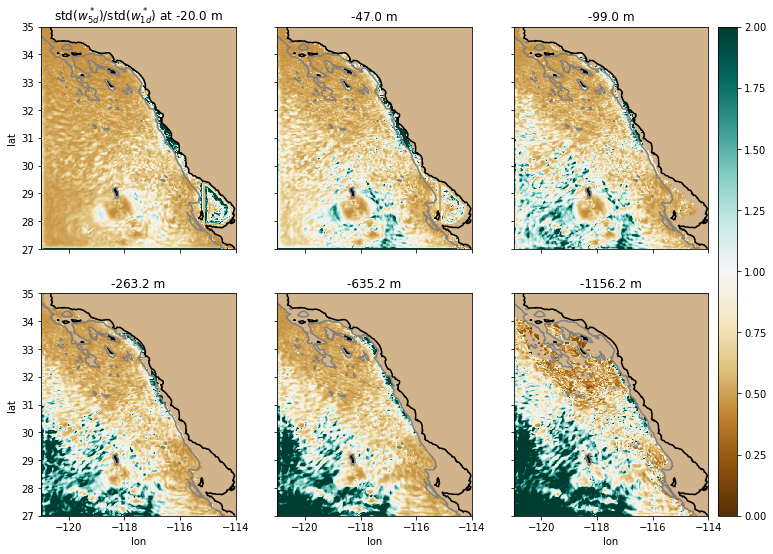

In [24]:
print('12 hrs/1 day')

ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1a/Std1b,Std2a/Std2b,Std3a/Std3b,Std4a/Std4b,Std5a/Std5b,Std6a/Std5b,
                                       0,2,'BrBG','','std($w^*_{12h}$)/std($w^*_{1d}$)')
plt.show()

print('2.5 days/1 day')

ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1c/Std1b,Std2c/Std2b,Std3c/Std3b,Std4c/Std4b,Std5c/Std5b,Std6c/Std5b,
                                       0,2,'BrBG','','std($w^*_{2.5d}$)/std($w^*_{1d}$)')
plt.show()

print('5 days/1 day')
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1d/Std1b,Std2d/Std2b,Std3d/Std3b,Std4d/Std4b,Std5d/Std5b,Std6d/Std5b,
                                       0,2,'BrBG','','std($w^*_{5d}$)/std($w^*_{1d}$)')
plt.show()

12 hrs/1 day


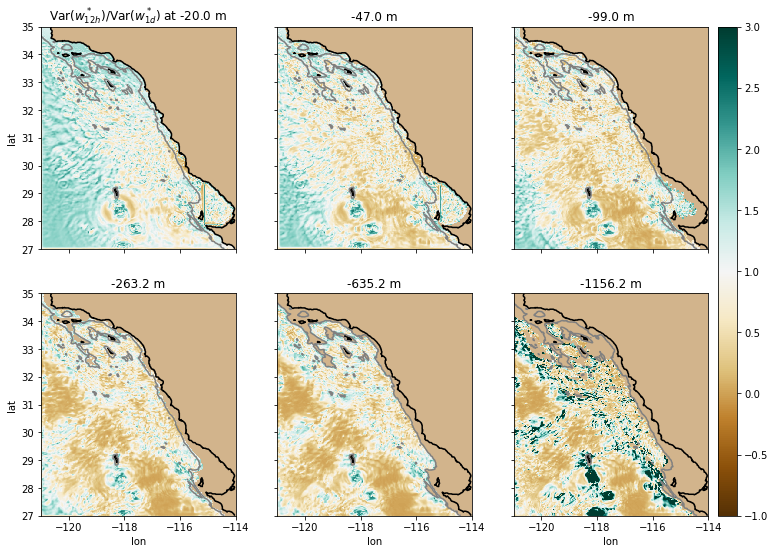

2.5 days/1 day


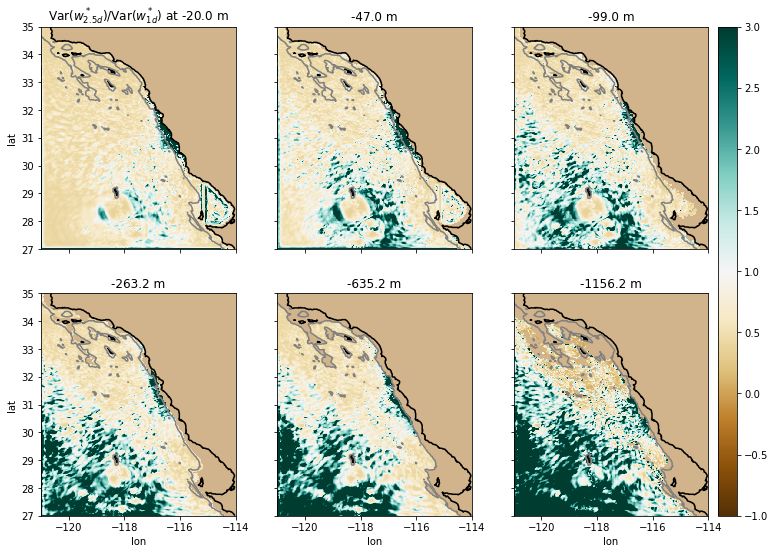

5 days/1 day


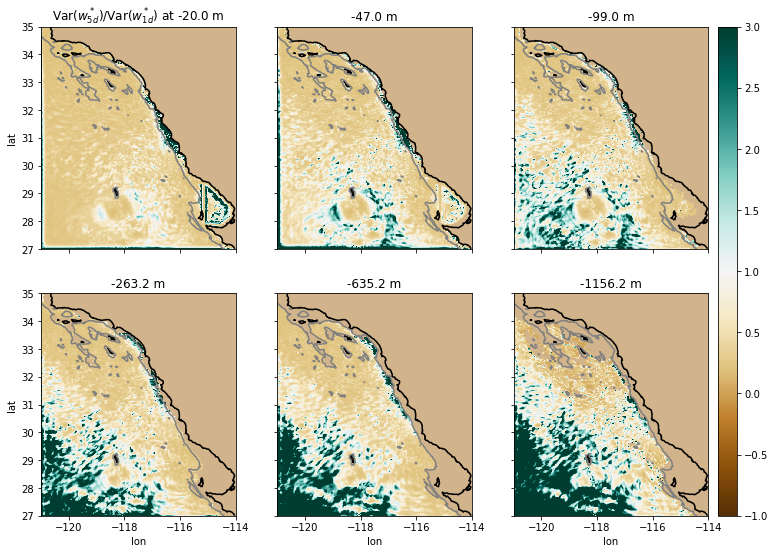

In [26]:
print('12 hrs/1 day')

ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1a/Var1b,Var2a/Var2b,Var3a/Var3b,Var4a/Var4b,Var5a/Var5b,Var6a/Var5b,
                                       -1,3,'BrBG','','Var($w^*_{12h}$)/Var($w^*_{1d}$)')
plt.show()

print('2.5 days/1 day')

ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1c/Var1b,Var2c/Var2b,Var3c/Var3b,Var4c/Var4b,Var5c/Var5b,Var6c/Var5b,
                                       -1,3,'BrBG','','Var($w^*_{2.5d}$)/Var($w^*_{1d}$)')
plt.show()

print('5 days/1 day')
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1d/Var1b,Var2d/Var2b,Var3d/Var3b,Var4d/Var4b,Var5d/Var5b,Var6d/Var5b,
                                       -1,3,'BrBG','','Var($w^*_{5d}$)/Var($w^*_{1d}$)')
plt.show()


### Profiles 

In [ ]:
def plot_profile(ax,Z, 
                 tot_fld_a, A1_fld_a, A2_fld_a, A3_fld_a, A4_fld_a,
                 tot_fld_b, A1_fld_b, A2_fld_b, A3_fld_b, A4_fld_b,
                 tot_fld_c, A1_fld_c, A2_fld_c, A3_fld_c, A4_fld_c,
                 tot_fld_d, A1_fld_d, A2_fld_d, A3_fld_d, A4_fld_d,
                 xlab, ylab, title, colors=['#4e0407','#bc0a0f','#dfa119','#138178'])

    ax.plot(Z[1:-1], tot_fld_a, 'k-', label='total 12 hr')
    ax.plot(Z[1:-1], tot_fld_b, 'k--', label='total 1 day')
    ax.plot(Z[1:-1], tot_fld_c, 'k:', label='total 2.5 days')
    ax.plot(Z[1:-1], tot_fld_d, 'k-.', label='total 5 days')

    ax.plot(Z[1:-1], A1_fld_a, '-', color=colors[0] , label='A1 12 hr')
    ax.plot(Z[1:-1], A1_fld_b, '--', color=colors[0] ,label='A1 1 day')
    ax.plot(Z[1:-1], A1_fld_c, ':', color=colors[0] ,label='A1 2.5 days')
    ax.plot(Z[1:-1], A1_fld_d, '-.', color=colors[0] ,label='A1 5 days')

    ax.plot(Z[1:-1], A2_fld_a, '-', color=colors[1] , label='A2 12 hr')
    ax.plot(Z[1:-1], A2_fld_b, '--', color=colors[1] ,label='A2 1 day')
    ax.plot(Z[1:-1], A2_fld_c, ':', color=colors[1],label='A2 2.5 days')
    ax.plot(Z[1:-1], A2_fld_d, '-.', color=colors[1] ,label='A2 5 days')

    ax.plot(Z[1:-1], A3_fld_a, '-', color=colors[2] , label='A3 12 hr')
    ax.plot(Z[1:-1], A3_fld_b, '--', color=colors[2] ,label='A3 1 day')
    ax.plot(Z[1:-1], A3_fld_c, ':', color=colors[2],label='A3 2.5 days')
    ax.plot(Z[1:-1], A3_fld_d, '-.', color=colors[2] ,label='A3 5 days')

    ax.plot(Z[1:-1], A4_fld_a, '-', color=colors[4] , label='A4 12 hr')
    ax.plot(Z[1:-1], A4_fld_b, '--', color=colors[4] ,label='A4 1 day')
    ax.plot(Z[1:-1], A4_fld_c, ':', color=colors[4],label='A4 2.5 days')
    ax.plot(Z[1:-1], A4_fld_d, '-.', color=colors[4] ,label='A4 5 days')

    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.legend()

    return(ax)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9,3), sharey=True)

ax1= plot_profile(ax,Z, 
                  W_tot_a, W_A1_a, W_A2_a, W_A3_a, 
                  W_tot_b, W_A1_b, W_A2_b, W_A3_b, 
                  W_tot_c, W_A1_c, W_A2_c, W_A3_c, 
                  W_tot_d, W_A1_d, W_A2_d, W_A4_d,
                  '$w^*$ (m s$^{-1}$)', 'Depth (m)','', colors=['#4e0407','#bc0a0f','#dfa119','#138178'])

ax2= plot_profile(ax,Z, 
                  Var_tot_a, Var_A1_a, Var_A2_a, Var_A3_a, 
                  VAr_tot_b, Var_A1_b, Var_A2_b, Var_A3_b, 
                  Var_tot_c, Var_A1_c, Var_A2_c, Var_A3_c, 
                  Var_tot_d, Var_A1_d, Var_A2_d, Var_A4_d,
                  '$<Var^{*2}>$ (m^2 s$^{-2}$)', 'Depth (m)','', colors=['#4e0407','#bc0a0f','#dfa119','#138178'])

ax3= plot_profile(ax,Z, 
                  Std_tot_a, Std_A1_a, Std_A2_a, Std_A3_a, 
                  Std_tot_b, Std_A1_b, Std_A2_b, Std_A3_b, 
                  Std_tot_c, Std_A1_c, Std_A2_c, Std_A3_c, 
                  Std_tot_d, Std_A1_d, Std_A2_d, Std_A4_d,
                  '$std(Std^*)$ (m s$^{-1}$)', 'Depth (m)','', colors=['#4e0407','#bc0a0f','#dfa119','#138178'])